# gen3-opfb

This notebook tests the functionality of the gen3-opfb through the FIR reorder.

## 1. Imports, Definitions, and Instantiating the overlay

In [1]:
from mkidgen3.daccomb import generate as gen_comb
from mkidgen3.pynq import dma_status  ## also activates the drivers
import logging
import numpy as np
import time
import pynq
from pynq import PL
from pynq import Overlay
from pynq import DefaultIP
from pynq import allocate
from fpbinary import FpBinary, OverflowEnum, RoundingEnum
import itertools
import matplotlib.pyplot as plt
from scipy.signal import welch

FP16_15=lambda x: FpBinary(int_bits=1, frac_bits=15, signed=True, value=x)
FP26_26=lambda x: FpBinary(int_bits=0, frac_bits=26, signed=True, value=x)
FP16_26=lambda x: FpBinary(int_bits=-10, frac_bits=26, signed=True, value=x)
FP32_31=lambda x: FpBinary(int_bits=1, frac_bits=31, signed=True, value=x)
FP18_17=lambda x: FpBinary(int_bits=1, frac_bits=17, signed=True, value=x)

logging.basicConfig()

n_res = 2048
n_bin = 4096

first_good_packet=17 # sixteen to prime the FIR and 1 of latency
latency_shift=3*16
n_packets_rcvd, n_packets_sent, next_sample_send = 0, 0, 0

We've had some issues with unexpected ZCU111 hangs and this was suggesting as a stabilizing measure on the PYNQ forums. This configuration is designed to enable timeouts for PS/PL AXI connnections.

In [2]:
mmio  = pynq.MMIO(0xFD610000 , 64)
mmio.write(0x18, 7) # Return slave errors when timeouts occur
mmio.write(0x20, 0x1020) # Set and enable prescale of 32 which should be about 10 ms
mmio.write(0x10, 0x7) # Enable transactions tracking
mmio.write(0x14, 0x7) # Enable timeouts

Load the overlay and extract the dma core

In [3]:
ol = Overlay('/home/xilinx/overlayfiles/opfb/opfb.bit')
ol.download()
dma = ol.axi_dma_0
print(f"PL Bitfile: {PL.bitfile_name}\nPL Timestamp: {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")
dma_status(dma)

PL Bitfile: /home/xilinx/overlayfiles/opfb/opfb.bit
PL Timestamp: 2020/4/16 3:47:13 +838162
Overlay timestamp: 2020/4/16 3:47:13 +838162  Loaded: True
DMA:
 MM2s
 Idle:False
 MM2S_DMASR (status):0x0
 MM2S_SA (ptr) :0x0
 MM2S_LENGTH (len):0
 S2MM
 Idle:False
 S2MM_DMASR (status):0x0
 S2MM_DA (ptr) :0x0
 S2MM_LENGTH (len):0


## Reading and writing DMA

Prepare some functions to convert numpy data to and from the correct data format.

Keep in mind the cores are based around 256 groups of 8 or 16 samples in parallel. Each sample is either 2 or 4 bytes depending on if they are real or complex. We are sending in a 256 bit stream that will be split into 128 low (I) and 128 high bits (Q), each transaction of which consists of 8 16 bit numbers. The TLAST of the DMA serves as a trigger to the large AXIS FIFO (4096 deep) in the OL that is configured in packet mode to trigger streaming though the opfb cores (data doesn't flow until the DMA write is done). This supports sending up to 16 packets (256 groups of 8 samples) at a time. The adc2opfb core will provide a tlast to the FIR every 512 transactions (1 stream beat).

Since one packet contains 2048 samples it results in 128 new values being fed into each lane packet[0-7::32] is lane0-7 real, packet[0-7 + 8::32] are lane0-7 imag. packet[0-7 + 16::32] is lane8-15 real and packet[0-7 + 24::32] the iamginary. The other 128 values that are sent down the lane are pulled by the adc2fir core from the respective lanes' shift registers. The ADC 2 FIR [sheet](https://docs.google.com/spreadsheets/d/1Aq9HyYat-zHmeC_wIC7wDO6Zweh_Myets_AHY71ldlU/edit#gid=0) in the linked google doc shows the resulting output of a C/RTL simulation of the core when fed with ADC "samples" composed of a ramp of reals. i.e. The first transaction in the beat is 0,1,2,3,4,5,6,7; the second, 8,9,10,11,...15 etc. Note that this matches the order of samples in Jenny's FPGA PDF with the delayed sample numbers interleaved with the non-delayed numbers.

The FIR cores (one per lane) are configured with 256 coefficient sets of 8 taps each so that floor(channel/2) gives the coefficient set used. They are not configured to blank the output until the taps are fully loaded. Two stream beats (two packets sent) will fill one tap for all 512 channels (256 channels and their 256 delayed counterparts). So packets 0-13 fill the first 7 taps. Packet 14 and 15 will place data into the last tap. 

The output of the FIRs feeds into the fir2fft core which de-interleaves and buffers the delayed and non-delayed samples in each stream beat. It replays them, non-delayed followed by the delayed samples reordered so that the output ADC sample subseries is convolved with FIR coefficients needed by the FFT. See the FIR 2 FFT sheet in the aformentioned google sheet for the results of the C/RTL simulation on the reorder core.

The reorder core feeds transactions into an 4096 deep (16 packets) AXIS FIFO that is not in packet mode, so it passes things along as soon as the AXI DMA is ready. Since the blocks have latency you can only recieve one less packet than is sent. All recieve operations must be one packet at a time because the TLAST is generated by the reoder core. 

The resulting output stream is similar to the input, though it consists of groups of 16 complex numbers due to the oversampling and is also joins the I and Q values (512 bits, 16x32b, 16 `complex<ap_fixed<-9,25>>`). So the packet needs to be read into a buffer of 8192 uint16s. buffer[::32] is lane0real buffer[1::32] is lane0imag and so forth. 

This overlay is equiped with a System ILA with an 8192 deep capture buffer.
- Slot0: adc2fir lane0 output
- Slot1: fir0 (lane0 output)
- Slot2: reorder output (all lanes combined)
- probe0: fir0 interrupts bit0-3: tlast missing, tlast unexpected, config tlast missing, config tlast unexpected
- probe1: fir0 TUSER (ChanID Valid bit0 & ChanID bits1-9)

### Create functions to help mode the data

A pair to convert to and from floating point

In [4]:
# 0.75/np.abs(comb.real).max() = 382.....
SCALE_IN=382.65305668618328*2**15
SCALE_OUT=1/(.75*2**9)
def packet_to_buffer(packet, zero_i=tuple(), zero_q=tuple(), fp=True, scale=SCALE_IN):
    """
    Converts a packet of complex data into a n_res*2 uint16 array
    
    Packet should be an array of dtype=np.complex64 or 128. length must be a multiple of 16
    
    zero_i & zero_q may be set to a tuple to selectively zero out values going into specific lanes
    
    Setting fp = False will result in the real and imaginaty values being multiplied by scale 
    and then cast to uint16. Otherwise FpBinary will be used to convert the data from float to signed 16_15.
    """
    if fp:
        ibits=[FP16_15(x).__index__() for x in packet.real]
        qbits=[FP16_15(x).__index__() for x in packet.imag]
    else:
        ibits=(packet.real*scale).astype(np.uint16)
        qbits=(packet.imag*scale).astype(np.uint16)
    data=np.zeros(2*packet.size, dtype=np.uint16)
    for i in range(8):
        data[i::16] = 0 if i in zero_i else ibits[i::8]
        data[i+8::16] = 0 if i in zero_q else qbits[i::8]
    return data

def packet_from_buffer(buffer, fp=True, scale=SCALE_OUT):
    """
    Converts a buffer of uint16 fixed point data to a np.complex128. 
    
    Buffer must be in multiples of 2*n_bin.
    """
    ibits=np.zeros(buffer.size//2, dtype=np.uint16)
    qbits=np.zeros(buffer.size//2, dtype=np.uint16)
    for i in range(16):
        ibits[i::16]=buffer[2*i::32]
        qbits[i::16]=buffer[2*i+1::32]
    
    packet=np.zeros(buffer.size//2, dtype=np.complex128)
    if fp:
        packet.real=[float(FpBinary(int_bits=-9, frac_bits=25, signed=True, bit_field=int(x))) for x in ibits]
        packet.imag=[float(FpBinary(int_bits=-9, frac_bits=25, signed=True, bit_field=int(x))) for x in qbits]
    else:
        packet.real=ibits*scale
        packet.imag=qbits*scale
        
    return packet

And one to prepare xilinx buffers

In [5]:
def prep_buffers(ntx=16):
    """ 
    ntx: How many packets do we send per DMA transfer. 
         Must be <=16 to move the stream smoothly through the core
    """
    global pptx, input_buffer, output_buffer
    pptx=ntx
    
    try: 
        #Close buffers if they are open
        input_buffer.close()
        output_buffer.close()
    except NameError:
        pass

    #Create the buffers
    n_in_buff = n_res*2*pptx if n_packets_sent else n_res*2*pptx+latency_shift*2
    input_buffer = allocate(shape=(n_in_buff,), dtype=np.uint16)  #2048 I & Q
    output_buffer = allocate(shape=(n_bin*2,), dtype=np.uint16)

Functions to send and receive multiple packets (uses some globals we will define later)

In [6]:
def init_pipe():
    """Send one packet's worth of 0s down the line."""
    if n_packets_sent==0:
        foo = allocate(shape=n_res*2, dtype=np.uint16)
        foo[:]=0
        dma.sendchannel.transfer(foo)
        dma.sendchannel.wait()
        foo.close()
        
def txpackets(packets, **kwargs):
    """
    Send packets to the FPGA and increment the number of packets sent. The number of packets 
    must correspond to the number specified in prep_buffers.
    """
    global n_packets_sent, pptx, input_buffer
    input_buffer[:]=np.array([packet_to_buffer(p, **kwargs) for p in packets]).ravel()
    dma.sendchannel.transfer(input_buffer)
    dma.sendchannel.wait()
    n_packets_sent+=pptx
    
def txcomb(**kwargs):
    global n_packets_sent, pptx, input_buffer, next_sample_send
      #92/2 empirically determined to overcome reorder core latency

    if n_packets_sent:
        n_to_send=pptx*n_res
        data=comb.ravel()[next_sample_send:next_sample_send+n_to_send]
        input_buffer[:]=packet_to_buffer(data, **kwargs)
    else:
        n_to_send=(pptx-1)*n_res + latency_shift
        data=comb.ravel()[next_sample_send:next_sample_send+n_to_send]
        input_buffer[:n_res*2]=0
        input_buffer[n_res*2:]=packet_to_buffer(data, **kwargs)
    dma.sendchannel.transfer(input_buffer)
    dma.sendchannel.wait()
    next_sample_send+=n_to_send
    n_packets_sent=1+next_sample_send//n_res

def rxpackets(n=None, status=False, **kwargs):
    """Attempts to receive packets. If no number is specified then n_outstanding-1 are received."""
    global n_packets_sent, n_packets_rcvd
    if n is None:
        n=n_packets_sent-n_packets_rcvd
    for i in range(n-1):
        if status:
            print(f"Receiving {pprx} packet(s) starting with {n_packets_rcvd}")
        dma.recvchannel.transfer(output_buffer)
        dma.recvchannel.wait()
        converted=packet_from_buffer(output_buffer,**kwargs)
        packets_out[n_packets_rcvd]=converted
        n_packets_rcvd+=1
    return converted

One to flush the pipeline

In [7]:
def flush(n=2):
    """Flush the pipeline n times with 16 packets worth of 0s and reset acket sent and recieved counters"""
    prep_buffers(16)
    global n_packets_sent,n_packets_rcvd, ramp0_n
    for i in range(n):
        input_buffer[:]=0
        dma.sendchannel.transfer(input_buffer)
        dma.sendchannel.wait()
        input_buffer[:]=1
        n_packets_sent+=pptx
        rxpackets(pptx)  #output is twice as large per packet
    n_packets_sent,n_packets_rcvd=0,0

# Generate and feed a stream

Both the resonator packets and the downconverted packets are $8kB = 256~cycles \cdot256~bits/cycle$, probably I0I1...I7Q0...Q7. So that is 4096 16 bit numbers, note that operations like input_buffer[5:]=999 will kill the kernel (at least sometimes)!

We need to send two packets  to ensure we drive the last transfer of the first packet all the way through the core (the core latency is ~30).

input_buffer = allocate(shape=(n_res*2,), dtype=np.uint16)
output_buffer = allocate(shape=(n_res*2,), dtype=np.uint16)

First create a timeseries of IQ values for a bin in it.
A 1Hz signal would have 2M samples

## Load the coefficients and matlab reference data
We may want to reference them in various places

In [8]:
coeffs=np.zeros((16,256,8))  #lane, coeff set, c7-0
for i in range(16):
    with open(f"data/lane{i}.coe",'r') as f:
        lines=f.readlines()[1:]
    lines[0]=lines[0].partition('=')[-1]
    coeffs[i]=np.array(list(map(float,''.join(lines).replace(';','').replace('\n','').split(',')))).reshape(256,8)

Import matlab results

In [9]:
try:
    with np.load("matlabsim_out.npz") as d:
        matlab_sim_out=d['matlab_sim_out']
except IOError:
    with open('matlabsim_out.csv') as f:
        lines=f.readlines()
        matlab_sim_out = np.array([list(map(np.complex, x)) for x in 
                                   map(lambda x: x.replace('i','j').split(','), lines)], 
                                  dtype=np.complex64)
    np.savez(f"matlabsim_out.npz", matlab_sim_out=matlab_sim_out)
matlab_sim_out=matlab_sim_out.reshape(matlab_sim_out.shape[0],256,16)

## Prepare the Data

What tones we want to send? Note these don't matter if we set use_matlab_input to True

In [10]:
use_matlab_input=True

n_total_packets=128+16+3           #How many packets
n_samples=256*n_total_packets*8  #How many waveform samples do we need to generate
sample_rate=4.096e9

freq=np.array([-300, 100, 151, 1000.5])*1e6  # -2048-2047
amplitudes = np.ones_like(freq)/n_res
phases=np.zeros_like(freq)

Generate the complex waveform

In [11]:
if not use_matlab_input:
    t = 2 * np.pi * np.arange(n_samples)/sample_rate
    comb=np.zeros(n_samples, dtype=np.complex64)
    for i in range(freq.size):
        comb += amplitudes[i] * np.exp(1j * (t * freq[i] + phases[i]))
else:
    try:
        with np.load("matlabsim_in.npz") as d:
            comb=d['comb']
    except IOError:
        with open('matlabsim_in.csv') as f:
            lines=f.read()
        comb=np.array(list(map(np.complex,lines.replace('i','j').split(','))), dtype=np.complex64)
        np.savez("matlabsim_in.npz", comb=comb)
comb=comb.reshape(comb.size//n_res, n_res)
print(f"Comb shape: {comb.shape}. \nTotal Samples: {comb.size}. Memory: {comb.size*8/1024**2:.0f} MB\n"
      f"Max value: {np.abs(comb).max()}.\n"
      f"Expected tone amplitude factor: ~512 * N_TONES_IN_BIN. (4096/8 as FFT scale dfaults to 8 in last 3 stages)\n"
      f"Resulting samples per output bin: {comb.size*2/n_bin}")

Comb shape: (1280, 2048). 
Total Samples: 2621440. Memory: 20 MB
Max value: 0.0019600000232458115.
Expected tone amplitude factor: ~512 * N_TONES_IN_BIN. (4096/8 as FFT scale dfaults to 8 in last 3 stages)
Resulting samples per output bin: 1280.0


Plot an FFT of the first full timeseries

In [12]:
if False:
    plt.figure(figsize=(7,4))
    plt.plot(np.fft.fftfreq(comb.size, d=1/sample_rate)/1e9, 
             np.abs(np.fft.fft(comb.ravel(), norm='ortho')))
    plt.xlim(-sample_rate/2e9,sample_rate/2e9);
    plt.xlabel('Freq (GHz)');

## Prepare an output array

In [13]:
packets_out=np.zeros((comb.shape[0], n_bin), dtype=np.complex64)

## Show what will be sent

Show an example of what will be on the wires.

In [14]:
foo=packet_to_buffer(comb[0], fp=False).reshape(128,2,2,8).astype(np.int16) #sample, even|odd, real|imag, adc port 0-7
print("Packet 0")
print(f"PFB Lane0 (iADC0 Evens): {foo[:,0,0,0][[0,1,2,3]]}...{foo[:,0,0,0][[-4,-3,-2,-1]]}")
print(f"PFB Lane0 (qADC0 Evens): {foo[:,0,1,0][[0,1,2,3]]}...{foo[:,0,1,0][[-4,-3,-2,-1]]}")
print(f"PFB Lane1 (iADC1 Evens): {foo[:,0,0,1][[0,1,2,3]]}...{foo[:,0,0,1][[-4,-3,-2,-1]]}")
print(f"PFB Lane8 (iADC0 Odds): {foo[:,1,0,0][[0,1,2,3]]}...{foo[:,1,0,0][[-4,-3,-2,-1]]}")

foo=packet_to_buffer(comb[1], fp=False).reshape(128,2,2,8).astype(np.int16)
print("Packet 1")
print(f"PFB Lane0 (iADC0 Evens): {foo[:,0,0,0][[0,1,2,3]]}...{foo[:,0,0,0][[-4,-3,-2,-1]]}")
print(f"PFB Lane0 (qADC0 Evens): {foo[:,0,1,0][[0,1,2,3]]}...{foo[:,0,1,0][[-4,-3,-2,-1]]}")
print(f"PFB Lane1 (iADC1 Evens): {foo[:,0,0,1][[0,1,2,3]]}...{foo[:,0,0,1][[-4,-3,-2,-1]]}")
print(f"PFB Lane8 (iADC0 Odds): {foo[:,1,0,0][[0,1,2,3]]}...{foo[:,1,0,0][[-4,-3,-2,-1]]}")

foo=packet_to_buffer(comb[2], fp=False).reshape(128,2,2,8).astype(np.int16)
print("Packet 2")
print(f"PFB Lane0 (iADC0 Evens): {foo[:,0,0,0][[0,1,2,3]]}...{foo[:,0,0,0][[-4,-3,-2,-1]]}")
print(f"PFB Lane0 (qADC0 Evens): {foo[:,0,1,0][[0,1,2,3]]}...{foo[:,0,1,0][[-4,-3,-2,-1]]}")
print(f"PFB Lane1 (iADC1 Evens): {foo[:,0,0,1][[0,1,2,3]]}...{foo[:,0,0,1][[-4,-3,-2,-1]]}")
print(f"PFB Lane8 (iADC0 Odds): {foo[:,1,0,0][[0,1,2,3]]}...{foo[:,1,0,0][[-4,-3,-2,-1]]}")

Packet 0
PFB Lane0 (iADC0 Evens): [ 24576  -5025 -21732  13223]...[-4018  -400  6025   464]
PFB Lane0 (qADC0 Evens): [     0 -11563   8667   6279]...[-12047   3375  12946  -7344]
PFB Lane1 (iADC1 Evens): [ 23608   1795 -23483   7536]...[-3893 -1801  5658  2707]
PFB Lane8 (iADC0 Odds): [-15449  21448   6152 -22048]...[ 3149 -3334 -5319  6162]
Packet 1
PFB Lane0 (iADC0 Evens): [-9812  2392 13215 -8592]...[ 7247   636 -5592  3622]
PFB Lane0 (qADC0 Evens): [-11767  12194   7116 -15233]...[  5565 -19043    983  16141]
PFB Lane1 (iADC1 Evens): [-9688 -1009 14261 -4414]...[ 5906  2405 -5844  2456]
PFB Lane8 (iADC0 Odds): [  6694 -11471  -4861  17190]...[-6576  4957  1348 -5020]
Packet 2
PFB Lane0 (iADC0 Evens): [ 1994 -4718   930  3876]...[ -9506 -17644  16345   8996]
PFB Lane0 (qADC0 Evens): [ -4531 -12597   5307  10580]...[ -8456  14788   1388 -18400]
PFB Lane1 (iADC1 Evens): [ 3124 -4442  -321  4158]...[ -3413 -20633  11896  13546]
PFB Lane8 (iADC0 Odds): [ 2537  2995 -3888 -1306]...[ 2181

## Send the data
This takes a while. We send 12, then 8, then 12 to enble waveform capture across the FIR windup and transition into normal operation  

Now go arm the ILA if desired, uncomment these following three cells and execute them in turn to look at movement in the fabric.

In [15]:
prep_buffers(12)
#txpackets(comb[n_packets_sent:n_packets_sent+pptx], fp=use_fp)
txcomb()
rxpackets()
print(f"Sent: {n_packets_sent} Received: {n_packets_rcvd}. Pending: {n_packets_sent-n_packets_rcvd}")
prep_buffers(12) #Must reprep as from here on we don't need to bad

Sent: 12 Received: 11. Pending: 1


In [16]:
# prep_buffers(8)
# txpackets(comb[n_packets_sent:n_packets_sent+pptx], fp=use_fp)
# rxpackets(fp=use_fp)
# print(f"Sent: {n_packets_sent} Received: {n_packets_rcvd}. Pending: {n_packets_sent-n_packets_rcvd}")

In [17]:
# prep_buffers(12)
# txpackets(comb[n_packets_sent:n_packets_sent+pptx], fp=use_fp)
# rxpackets(fp=use_fp)
# print(f"Sent: {n_packets_sent} Received: {n_packets_rcvd}. Pending: {n_packets_sent-n_packets_rcvd}")

In [18]:
txcomb()
rxpackets()
print(f"Sent: {n_packets_sent} Received: {n_packets_rcvd}. Pending: {n_packets_sent-n_packets_rcvd}")

Sent: 24 Received: 23. Pending: 1


Send the rest (or all) of the packets in groups of 16. This a few seconds.

In [21]:
# prep_buffers(8)
for i in range((n_total_packets-n_packets_sent)//pptx):
    #txpackets(comb[n_packets_sent:n_packets_sent+pptx], fp=use_fp)
    txcomb()
    rxpackets()
    print(f"Sent: {n_packets_sent} Received: {n_packets_rcvd}. Pending: {n_packets_sent-n_packets_rcvd}")

Sent: 36 Received: 35. Pending: 1
Sent: 48 Received: 47. Pending: 1
Sent: 60 Received: 59. Pending: 1
Sent: 72 Received: 71. Pending: 1
Sent: 84 Received: 83. Pending: 1
Sent: 96 Received: 95. Pending: 1
Sent: 108 Received: 107. Pending: 1
Sent: 120 Received: 119. Pending: 1
Sent: 132 Received: 131. Pending: 1
Sent: 144 Received: 143. Pending: 1


And save the output to disk.

In [ ]:
np.savez(f"packets_out_opfb.npz",  
         freq=freq, phases=phases, amplitudes=amplitudes,
         packets_out=packets_out)

## Look at the results

Manually compute what we would expect for the first output with 8 taps from above for lane0. This should be on packet 16, yielding FIR clock outputs 1,3,...511 per jenny's PDF, and should be the 384th to 511th, 256th inputs to the FFT (so I think the matlab output samples would be those \*16).

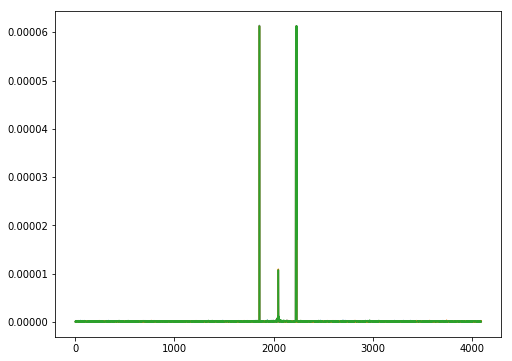

In [22]:
plt.figure(figsize=(8,6))
plt.plot(np.fft.fftshift(np.abs(packets_out[18])));
plt.plot(np.fft.fftshift(np.abs(packets_out[20])));
plt.plot(np.fft.fftshift(np.abs(packets_out[85])));

Now lets try and reproduce and find what we are getting. First lets define a function that given a lane and an fftclock cycle it will 

- Extract what we should see from the matlab golder output,
- Compute what we should see in python from the input,
- Compute what we should see in fixed point
- Extract the corresponding sample from the output (subject to varioud options to adjust where we look in the output)

In [ ]:
def fir(lane=0, fftclk=None, show=True, rollfpga_new=False, rollfpga_old=False, swapfpga=False, fpga_i=0, fpga_p=0):
    """Assumes comb.shape(N, 2048) matlab_sim_out.shape=(N,256,16)"""
    mlab_block=fftclk//256
    mlab_chan=fftclk%256  #fft order
    
    reorder=mlab_block%2
    packet_0=mlab_block #+ (1 if reorder else 0) #fir order
    coeff_chan=mlab_chan if not reorder else (mlab_chan+128)%256  #input order
    if coeff_chan<128:
        comb_chan = coeff_chan
    else:
        comb_chan = coeff_chan-128
        packet_0+=1
        
    pak_out=mlab_block+first_good_packet+fpga_p#+ #(-1 if swapfpga and reorder else 1)
    
    fpga_chan=mlab_chan+fpga_i
    if (rollfpga_old and reorder) or (rollfpga_new and not reorder):
        fpga_chan=(fpga_chan+128)
    fpga_chan%=256
    
    if show:
        print(f'Matlab block {mlab_block}, channel {mlab_chan}, lane {lane}')
        print(f'FIR Coeff channel {coeff_chan}')
        print(f'Delayed cycle needing reorder: {reorder}')
        print(f'Input samples {packet_0}-{packet_0+14} (by twos), channel {comb_chan} (i={16*comb_chan+lane})')
        print(f'FPGA Output packet {pak_out}, sample {fpga_chan} (i={fpga_chan*16+lane})')
    
    mlab=matlab_sim_out[mlab_block,mlab_chan,lane]
    pysamp=comb[packet_0:packet_0+15:2, 16*comb_chan+lane]
    
    taps=coeffs[lane,coeff_chan,::-1]
    fpdat=[(FP16_15(s.real),FP16_15(s.imag),FP16_26(c)) for s,c in zip(pysamp,taps)]
    fpreal, fpimag=sum(r*c for r,i,c in fpdat), sum(i*c for r,i,c in fpdat)
    py=(pysamp*taps).sum()
    pyfp=float(fpreal.resize((-9,25)))+float(fpimag.resize((-9,25)))*1j
    
    fpga=packets_out.reshape(packets_out.shape[0],256,16)[pak_out, fpga_chan ,lane]
    if show:
        print(f" Matlab:  {mlab:.3g}")  #256 clocks per packet we are looking for 384 so 2nd packet chan. 128
        print(f" Python:  {py:.3g}  (matlab diff {mlab-py:.0g})")
        print(f" FP16_25: {pyfp:.3g}  (min rep. diff {100*(py-pyfp)/2**-25:.0f}%)")
        print(f" FPGA[{pak_out},{fpga_chan*16+lane}]: {fpga:.3g}")
        print(f" Diff: {pyfp-fpga:.4g}")
    return mlab, py, pyfp, fpga

Now lets reshape all the packets and shoe some similar things graphically for packets 14-18

In [ ]:
data=packets_out.reshape(packets_out.shape[0],256,16)  # [packet, group number, lane]

Note that packet 14 has a non-zero value in most lanes (i.e. data[14,127,:].real, the FIRs are giving real data) on that particular output. Cycle 127 (the 128th) cycle of packet 14 is a reordered packet so it is channel 511 (maybe 510 if I've done something wrong in hardware) from the FIR. The input data for packet 14 placed populated the 8th tap for channels 0-255 of the FIR so this shouldn't be possible. The value on lane0 (packets_out[14].reshape(256,16)[127,0].real) is 1, which indicates it was multiplied by coefficient set 1, which would correspond to FIR channel 0 or 1. This is troubling and indicates something, but I don't understand what.

### Lets try and compute the FIR in python to see if we did what we said we'd do

Also do things with 16_15 and 18_17 fixed point math. This is slow.

In [23]:
packets_to_convert=164
assert packets_to_convert>=1+n_total_packets+2*7+2

#16_15 comb and 16_26 coeff
fpcoeff16_26l=[[[FP16_26(tap) for tap in channel] for channel in lane] for lane in coeffs]
fpcomb16_15l=[[[FP16_15(y.real),FP16_15(y.imag)] for y in x] for x in comb[:packets_to_convert]]
fpcomb16_15=np.empty((packets_to_convert, 2048, 2),dtype=object)
fpcoeff16_26=np.empty_like(coeffs, dtype=object)
fpcomb16_15[:,:,:]=fpcomb16_15l
fpcoeff16_26[:,:,:]=fpcoeff16_26l
del fpcomb16_15l, fpcoeff16_26l

In [24]:
def do_fixed_point_pfb(fpcomb,fpcoeff, truncate=True):
    """Set truncate to false to preserve the full output bitwidth. Truncation is done with FpBinary defaults."""
    fft_block=np.zeros((n_total_packets+1, 256, 16),dtype=np.complex64)
    for i in range(0,128,2):  #each packet of ADC samples, 128 new things to a lane 2 packets to feed all channels
        lane_out=np.zeros((2,256,16), dtype=np.complex64)
        for l in range(16):
            fresh=np.array([fpcoeff[l,:,7-c_i]*fpcomb[i+2*c_i:i+2*c_i+2, l::16,:].reshape(256,2).T 
                      for c_i in range(8)]).sum(axis=0)
            delay=np.roll(np.array([fpcoeff[l,:,7-c_i]*fpcomb[1+i+2*c_i:1+i+2*c_i+2, l::16,:].reshape(256,2).T 
                      for c_i in range(8)]).sum(axis=0),128, axis=1)
            #Sum the multiplies are roll the delayed samples
            if truncate:
                outformat=(-9, sum(fpcomb.flat[0].format)+9)
                conv= lambda a: np.array(list(map(lambda x:float(x.resize(outformat)) , a)))
                lane_out[0, :, l]=conv(fresh[0]) + conv(fresh[1])*1j
                lane_out[1, :, l]=conv(delay[0]) + conv(delay[1])*1j
            else:
                lane_out[0, :, l]=fresh[0].astype(float)+fresh[1].astype(float)*1j
                lane_out[1, :, l]=delay[0].astype(float)+delay[1].astype(float)*1j
        fft_block[i]=lane_out[0]
        fft_block[i+1]=lane_out[1]
    print(outformat)
    return fft_block

In [25]:
pfb_fp16=do_fixed_point_pfb(fpcomb16_15, fpcoeff16_26)

(-9, 25)


## Try taking the FFT manually


Some functions to process the data

In [26]:
def do_fft(datain, do_pfb_fft=False, sl=None, do_welch=False, roll_pfb_fft=0):
    data = datain.reshape(datain.shape[0], 256*16) if datain.ndim==3 else datain
    if sl is not None:
        data=data[sl]
    data = np.fft.fft(np.roll(data, roll_pfb_fft, axis=1), axis=1) if do_pfb_fft else data
    if do_welch:
        freq, data = welch(data, fs=2e6, return_onesided=False, scaling='spectrum', axis=0)
        data = np.fft.fftshift(data, axes=0)
        freq = np.fft.fftshift(freq, axes=0)
    else:
        data = np.fft.fftshift(np.fft.fft(data, axis=0), axes=0)
    return data

def extract_opfb_spec(data, OS=2, exclude_overlap=True, linear=False):
    if not exclude_overlap:
        raise NotImplementedError
    
    N, M = data.shape
    data=np.abs(data) if linear else 20*np.log10(np.abs(data))
    ndx_bin = int(np.ceil((OS-1)/(2*OS)*N))-1  #no overlap start of bin
    
    stride = int(np.floor(1/OS*N))+1
    yax_t = np.zeros(stride*M)
    xax_t = np.arange(M)[:,np.newaxis] + np.linspace(-.5, .5 - 1/stride, stride)
    
    ndx_out=0
    for i in range(M):
        yax_t[ndx_out:ndx_out + stride] = data[ndx_bin:ndx_bin+stride,i]
        ndx_out+=stride

    # shift the negative frequency components back to the correct place
    return xax_t.ravel() - M/2, np.fft.fftshift(yax_t)

## Plot the OPFB Spectra

In [ ]:
pltslc=slice(18,21)
fpgaplotdata = extract_opfb_spec(do_fft(packets_out, sl=pltslc))
mlabplotdata = extract_opfb_spec(do_fft(matlab_sim_out, do_pfb_fft=True, sl=slice(0,126)))
plt.figure(figsize=(15,7))
plt.plot(*mlabplotdata,label='mlab', linewidth=.8)
plt.plot(*fpgaplotdata, label='fpga', linewidth=.5)
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dB)')
plt.grid()
plt.title('OPFB Spectrum')
plt.show()

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(np.fft.fftshift(np.abs(packets_out[19])))
plt.xlim(1800,2200)

In [31]:
pltslc=slice(18,126)
fpgaplotdata = extract_opfb_spec(do_fft(packets_out*2**3, sl=pltslc))
mlabplotdata = extract_opfb_spec(do_fft(matlab_sim_out, do_pfb_fft=True, sl=slice(0,126)))
plotdata_fp16 = extract_opfb_spec(do_fft(pfb_fp16, sl=pltslc, do_pfb_fft=True, roll_pfb_fft=0))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


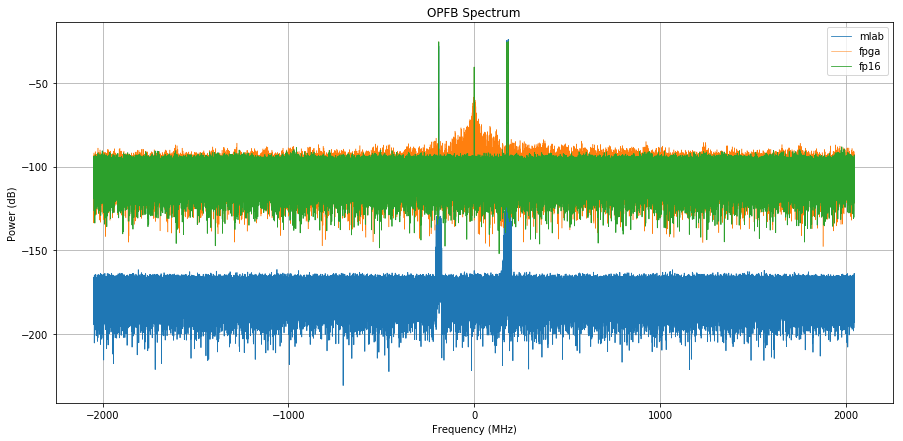

In [33]:
plt.figure(figsize=(15,7))
plt.plot(*mlabplotdata,label='mlab', linewidth=.8)
plt.plot(*fpgaplotdata, label='fpga', linewidth=.5)
plt.plot(*plotdata_fp16,label='fp16', linewidth=.8)
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dB)')
plt.grid()
plt.title('OPFB Spectrum')
plt.show()